In [257]:
import numpy as np
import pandas as pd
import seaborn as snsg_hexp
from css_utility import *
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

In [390]:
whole_gene_file

'../database/RefSeq/RefSeq.WholeGene.bed'

In [397]:
### First, whole gene for E050
# df_e050=bed2df_expanded("../database/bed/unzipped/E050_15_coreMarks_stateno.bed")
css_E050_gene_lst_all=compGene2css(whole_gene_file,df_e050)

Extracting the gene file ...
Done!


In [398]:
css_E050_gene_unit_lst_all=Convert2unitCSS_main(css_E050_gene_lst_all, unit=200)

Converting css from the raw length into unit-length ... 



Done!


In [403]:
g_e050_css_all_len=[len(elm) for elm in flatLst(css_E050_gene_unit_lst_all)]

Total count= 43982


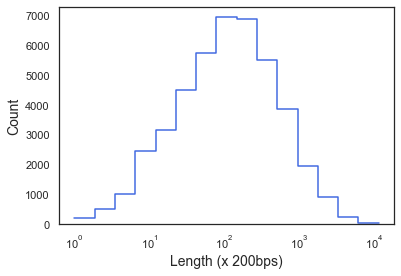

In [404]:
sns.histplot(g_e050_css_all_len,log_scale=True, element="step", fill=False, color="royalblue", bins=15)
print("Total count= {}".format(len(g_e050_css_all_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [69]:
path="../database/bed/gene_expression/"

In [200]:
g_hexp=pd.read_csv(path+"gene_highlyexpressed.refFlat", sep="\t", index_col=False, header=0)
# g_hexp.columns[0]="gene_id"
# g_hexp.index = g_hexp.iloc[:,0]
# g_hexp.index.rename("gene_id")

g_hexp=g_hexp.iloc[:,1:]
g_hexp.rename(columns={"name":"gene_id"}, inplace=True)
g_hexp.rename(columns={"#geneName":"geneName"}, inplace=True)
# g_exp.index = g_exp.iloc[:,0]

g_hexp.head()

,geneName,gene_id,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,gene type,transcript type,reference transcript name,reference transcript id
0,CD99,ENSG00000002586,chrX,+,2609219,2659350,2609401,2658845,10,"[2609219, 2632462, 2635645, 2637701, 2638396, ...","[2609468, 2632495, 2635693, 2637746, 2638465, ...",protein_coding,protein_coding,CD99-001,ENST00000381192
1,LASP1,ENSG00000002834,chr17,+,37026111,37078023,37026442,37075031,7,"[37026111, 37034338, 37046672, 37054664, 37070...","[37026511, 37034433, 37046757, 37054772, 37070...",protein_coding,protein_coding,LASP1-001,ENST00000318008
2,M6PR,ENSG00000003056,chr12,-,9092960,9102551,9094413,9099000,7,"[9092960, 9095011, 9096000, 9096396, 9098013, ...","[9094536, 9095138, 9096131, 9096506, 9098180, ...",protein_coding,protein_coding,M6PR-001,ENST00000000412
3,ARF5,ENSG00000004059,chr7,+,127228398,127231759,127228552,127231353,6,"[127228398, 127229136, 127229538, 127230119, 1...","[127228619, 127229217, 127229648, 127230191, 1...",protein_coding,protein_coding,ARF5-001,ENST00000000233
4,FKBP4,ENSG00000004478,chr12,+,2904118,2913124,2904305,2912424,10,"[2904118, 2906303, 2906894, 2907871, 2908253, ...","[2904410, 2906448, 2907037, 2907992, 2908410, ...",protein_coding,protein_coding,FKBP4-001,ENST00000001008


In [258]:
# function for preprocess the whole gene data and produce chromosome-wise gene lists
# each element is dataframe

def Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/gene_highlyexpressed.refFlat'):
    print("Extracting the gene file ...")
    g_fn=exp_gene_file
    g_df_raw=pd.read_csv(g_fn, sep='\t', index_col=False, header=0)
    g_df=g_df_raw
    g_df=g_df.iloc[:,1:]
    g_df.rename(columns={"name":"gene_id"}, inplace=True)
    g_df.rename(columns={"#geneName":"geneName"}, inplace=True)
    g_df.rename(columns={"txStart":"TxStart"}, inplace=True) # to make it coherent to my previous codes
    g_df.rename(columns={"txEnd":"TxEnd"}, inplace=True)
#     g_df=g_df_raw.rename(columns={0:"geneName",1:"gene_id",2:"chrom",3:"strand",4:"txStart",5:"txEnd",
#                                       6:"cdsStart",7:"cdsEnd",8:"exonCount",9:"exonStart",10:"exonEnds",
#                                       11:"gene type",12:"transcript type",13:"reference transcript name",
#                                       14:"reference transcription id"})
    ## string to the list of "int", for exon start/end ##
    g_df_temp=g_df # copy for processing
    exon_start_int_lst=[]
    for i, str_lst in enumerate(g_df_temp["exonStarts"]):
        int_lst=[int(elm) for elm in str_lst.replace("[","").replace("]","").split(",")]
        assert g_df_temp["exonCount"][i]==len(int_lst) # make sure the no. element in exon start = count
        exon_start_int_lst.append(int_lst)    
    g_df_temp["exonStarts"]=exon_start_int_lst

    exon_end_int_lst=[]
    for i, str_lst in enumerate(g_df_temp["exonEnds"]):
        int_lst=[int(elm) for elm in str_lst.replace("[","").replace("]","").split(",")]
        assert g_df_temp["exonCount"][i]==len(int_lst) # make sure the no. element in exon start = count
        exon_end_int_lst.append(int_lst)    
    g_df_temp["exonEnds"]=exon_end_int_lst    
    g_df=g_df_temp # and make it back the original name
        
    g_df=g_df[["geneName","gene_id","chrom","TxStart","TxEnd"]] # extract these only
    
    # Remove other than regular chromosomes
    chr_lst=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
             'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
             'chr20','chr21','chr22','chrX','chrY']
    g_df=g_df.loc[g_df["chrom"].isin(chr_lst)]
    
    # Create a list of chromosome-wise dataframe 
    g_df_chr_lst=[]
    for num in range(len(chr_lst)):
        chr_num=chr_lst[num]
        g_chr_df='g_'+chr_num  # name it as "g_"
        locals()[g_chr_df]=g_df[g_df["chrom"]==chr_num]
        g_chr_df=locals()[g_chr_df]
        g_chr_df=g_chr_df.sort_values("TxStart")
        g_df_chr_lst.append(g_chr_df)
        
    # Remove the overlapped area (using removeOverlapDF function in css_utility.py)
    g_df_chr_collapsed_lst=[]
    for g_df_chr in g_df_chr_lst:
        g_df_chr_collapsed=removeOverlapDF(g_df_chr)
        assert len(g_df_chr)>=len(g_df_chr_collapsed)
        g_df_chr_collapsed_lst.append(g_df_chr_collapsed)
    print("Done!")
    
    return g_df_chr_collapsed_lst  # list of dataframe

In [259]:
# highly expressed case
g_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/gene_highlyexpressed.refFlat')

Extracting the gene file ...
Done!


In [376]:
# just expressed case
gexp_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/gene_expressed.refFlat')

Extracting the gene file ...
Done!


In [381]:
# just expressed case - convert to css 
css_exp_gene_lst_all=comp_expGene2css("../database/bed/gene_expression/gene_expressed.refFlat",df_e050)
css_exp_unit_lst_all=Convert2unitCSS_main(css_exp_gene_lst_all, unit=200)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...



Done!
Converting css from the raw length into unit-length ... 



Done!


In [382]:
g_exp_css_all=flatLst(css_exp_unit_lst_all)

In [383]:
len(g_exp_css_all)

13469

In [384]:
g_exp_css_all_len=[len(elm) for elm in g_exp_css_all]

Total count= 13469


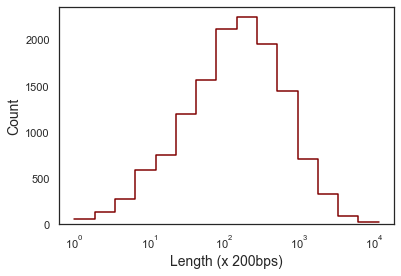

In [389]:
sns.histplot(g_exp_css_all_len,log_scale=True, element="step", fill=False, color="maroon", bins=15)
print("Total count= {}".format(len(g_exp_css_all_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

### So now we have bed files for highly expressed.. then we need CSS for E050 

In [260]:
df_e050=bed2df_expanded("../database/bed/unzipped/E050_15_coreMarks_stateno.bed")
df_e050.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,13200,15,2600,13,O,OOOOOOOOOOOOO
3,chr1,13200,13400,7,200,1,G,G
4,chr1,13400,28400,5,15000,75,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...


In [395]:
df_e050.tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
485249,chrY,58972000,58997400,8,25400,127,H,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...
485250,chrY,58997400,59001600,9,4200,21,I,IIIIIIIIIIIIIIIIIIIII
485251,chrY,59001600,59002200,8,600,3,H,HHH
485252,chrY,59002200,59033400,9,31200,156,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
485253,chrY,59033400,59373400,15,340000,1700,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [394]:
len(df_e050)

485254

In [262]:
all_unit_css=df2unitcss(df_e050)

In [265]:
len(all_unit_css[0]) # unit length

1246253

In [266]:
css_lst_chr=df2longcss(df_e050)

In [268]:
len(css_lst_chr[0]) # original 

249250600

In [289]:
def comp_expGene2css(exp_gene_file,df):   # df indicates css, created by bed2df_expanded
    """
    modified from `compGene2css`
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at genic area only.
    """
    g_lst_chr=Gexp_Gene2GLChr(exp_gene_file)
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    print("Matching to the chromatin state sequence data ...")
    css_gene_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    
    # remove chromosome if it is empty (e.g. chrY for female)
    css_gene_lst_all=[elm for elm in css_gene_lst_all if elm!=[]] 
            
    print("Done!")
    return css_gene_lst_all ## this is the original length! reduce it at Convert2unitCSS_main(css_lst_all, unit=200)!

In [290]:
css_gene_lst_all=comp_expGene2css("../database/bed/gene_expression/gene_highlyexpressed.refFlat",df_e050)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...



Done!


In [291]:
css_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)

Converting css from the raw length into unit-length ... 



Done!


In [296]:
len(css_unit_lst_all[0])

121

In [293]:
g_hexp_css_all=flatLst(css_unit_lst_all)

In [380]:
len(g_hexp_css_all)

1051

In [298]:
g_hexp_css_all[-1]

'AABBBGEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGGGEEEEEEEEEEEEEEEEEEEEEDDDEEEEEEEEEEDDDDDDDDDDDDDDDEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDEEEEEEDDDDDDDDDDDDDHHHHHHHEEEEEEEEEEEHHHHHHHEEEEEEEEEDDDDDDDDDDDDDDDDDDDDDDDDDEEEEEEEEEEEDDDDDDDDDDDDDHHHHHHHHHHHHHHHII'

In [299]:
g_hexp_css_len=[len(elm) for elm in g_hexp_css_all]

In [333]:
len(g_hexp_css_len)

1051

Total count= 1051


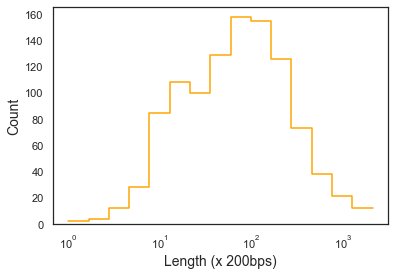

In [373]:
sns.set(rc={"font.size":15, "font.family":"serif"})
sns.set_style("white")
print("Total count= {}".format(len(g_hexp_css_len)))
p=sns.histplot(g_hexp_css_len, log_scale=True, element="step", fill=False, color="orange", bins=15)
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()
# p.set_xticks(p.get_xticks())
# p.set_xticklabels(p.get_xticks(), fontfamily="serif", fontsize=12)

#### Is this length normal..? looks like too short. Let me compare it with complexity case

In [361]:
with open("../database/temp_files/complexity/thres_mean/comp","rb") as f:
    comp_lst=pickle.load(f)

In [364]:
len(comp_lst)

37

In [365]:
comp_css_len=[len(elm) for elm in comp_lst]

Total count= 13484


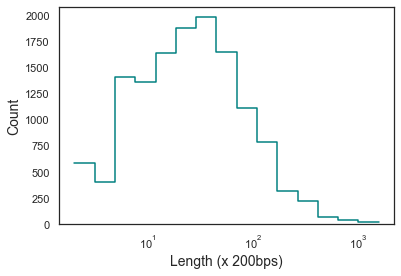

In [375]:
sns.histplot(comp_css_len,log_scale=True,element="step", fill=False, color="teal", bins=15)
print("Total count= {}".format(len(comp_css_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

#### Convert string to int: exonStarts and exonEnds

In [124]:
exon_start_test=[int(elm) for elm in g_hexp["exonStarts"][0].replace("[","").replace("]","").split(",")]

In [125]:
exon_end_test=[int(elm) for elm in g_hexp["exonEnds"][0].replace("[","").replace("]","").split(",")]

#### Exon is short

In [128]:
np.array(exon_end_test)-np.array(exon_start_test)

array([249,  33,  48,  45,  69,  48,  51, 114,  57, 531])

#### Tx is long

33205.17153284672


<AxesSubplot:ylabel='Count'>

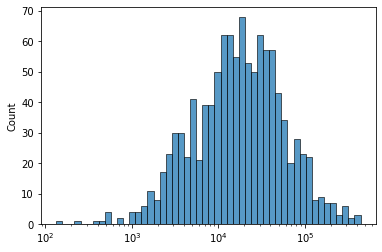

In [136]:
print(np.mean(g_hexp["txEnd"]-g_hexp["txStart"]))
sns.histplot(g_hexp["txEnd"]-g_hexp["txStart"], bins=50, log_scale=True)

In [90]:
g_hexp.sort_values("chrom", inplace=True)
g_hexp.head(20)

,geneName,gene_id,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,gene type,transcript type,reference transcript name,reference transcript id
674,TCTEX1D1,ENSG00000152760,chr1,+,67218142,67244470,67220341,67243137,5,"[67218142, 67220338, 67236069, 67241961, 67242...","[67218267, 67220460, 67236161, 67242086, 67244...",protein_coding,protein_coding,TCTEX1D1-001,ENST00000282670
5,KDM1A,ENSG00000004487,chr1,+,23345940,23410182,23346089,23409857,19,"[23345940, 23356961, 23376879, 23380253, 23381...","[23346440, 23357127, 23377013, 23380332, 23381...",protein_coding,protein_coding,KDM1A-001,ENST00000356634
1092,DCAF8,ENSG00000258465,chr1,-,160187253,160254920,160187381,160251981,18,"[160187253, 160188113, 160188638, 160192440, 1...","[160187498, 160188230, 160188758, 160192571, 1...",protein_coding,protein_coding,DCAF8-001,ENST00000556710
798,IRF2BP2,ENSG00000168264,chr1,-,234740014,234745271,234742882,234745240,2,"[234740014, 234744240]","[234743598, 234745271]",protein_coding,protein_coding,IRF2BP2-001,ENST00000366610
980,CDC42SE1,ENSG00000197622,chr1,-,151023446,151042801,151026722,151028206,8,"[151023446, 151026706, 151027491, 151028152, 1...","[151025803, 151026797, 151027602, 151028469, 1...",protein_coding,protein_coding,CDC42SE1-001,ENST00000439374
855,UQCRH,ENSG00000173660,chr1,+,46769302,46782448,46769438,46782256,4,"[46769302, 46774772, 46775826, 46782223]","[46769492, 46774799, 46775988, 46782448]",protein_coding,protein_coding,UQCRH-001,ENST00000311672
493,ZRANB2,ENSG00000132485,chr1,-,71528973,71546980,71530756,71546678,10,"[71528973, 71532458, 71534958, 71536509, 71537...","[71530820, 71532617, 71535045, 71536679, 71537...",protein_coding,protein_coding,ZRANB2-001,ENST00000370920
857,TOMM20,ENSG00000173726,chr1,-,235272650,235292251,235275378,235292030,5,"[235272650, 235277082, 235283132, 235285640, 2...","[235275423, 235277225, 235283214, 235285687, 2...",protein_coding,protein_coding,TOMM20-001,ENST00000366607
982,S100A10,ENSG00000197747,chr1,-,151955390,151966866,151955638,151958706,3,"[151955390, 151958574, 151966227]","[151955800, 151958727, 151966866]",protein_coding,protein_coding,S100A10-001,ENST00000368811
16,CSDE1,ENSG00000009307,chr1,-,115259533,115300604,115260789,115282511,19,"[115259533, 115261233, 115262199, 115263159, 1...","[115260837, 115261366, 115262363, 115263338, 1...",protein_coding,protein_coding,CSDE1-001,ENST00000339438


In [94]:
g_hexp["chrom"].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX'], dtype=object)

In [13]:
epi57_raw=pd.read_csv(path+"57epigenomes.RPKM.pc.tsv", sep="\t",index_col=False, header=0)

In [15]:
epi57_raw.head()

,gene_id,E000,E003,E004,E005,E006,E007,E011,E012,E013,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
0,ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
1,ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
2,ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
3,ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
4,ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [14]:
epi57=epi57_raw

In [6]:
epi57.head()

,gene_id,E000,E003,E004,E005,E006,E007,E011,E012,E013,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
0,ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
1,ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
2,ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
3,ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
4,ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [8]:
epi57.index = epi57.iloc[:,0]

In [10]:
epi57.head()

,gene_id,E000,E003,E004,E005,E006,E007,E011,E012,E013,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
ENSG00000000005,ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
ENSG00000000419,ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
ENSG00000000457,ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
ENSG00000000460,ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [11]:
epi57=epi57.iloc[:,1:]

In [12]:
epi57.head()

,E000,E003,E004,E005,E006,E007,E011,E012,E013,E016,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,44.280,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,1.577,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,51.515,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,3.292,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,7.551,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [18]:
len(epi57)

19795

In [17]:
epi57.describe()

,E000,E003,E004,E005,E006,E007,E011,E012,E013,E016,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
count,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.00000,19795.000000,19795.000000,19795.000000,...,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000
mean,15.616650,15.669690,16.786629,16.176443,16.627451,15.957653,14.25646,13.512338,14.372464,15.280072,...,15.369580,15.892908,14.933831,19.967192,20.046715,16.127057,18.468016,17.351987,19.204572,15.389853
std,59.060454,54.568895,72.916420,89.982958,96.150932,64.905445,49.29719,40.523499,51.430895,50.108760,...,70.770097,77.359634,49.595660,182.542526,165.263021,86.224347,97.655144,111.013555,173.338817,76.854728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.357500,0.118000,0.086000,0.064000,0.013000,0.064000,0.13900,0.110000,0.135000,0.139000,...,0.032000,0.013000,0.005000,0.012000,0.014000,0.023000,0.012000,0.007000,0.019000,0.014000
50%,4.682000,3.329000,2.653000,2.763000,2.360000,3.573000,4.14500,3.895000,3.729000,3.514000,...,2.602000,1.746000,1.826000,2.408000,2.395000,2.248000,2.198000,1.606000,2.476000,2.147000
75%,15.003500,13.404000,13.385000,12.443500,11.961000,14.279500,14.20450,14.176000,13.311500,13.955000,...,12.969500,13.590500,13.476500,12.422000,12.181500,11.598000,12.166000,13.679500,12.305500,11.519500
max,3445.470000,2211.915000,4517.905000,8590.590000,9123.360000,4063.105000,2688.12000,1574.320000,2935.310000,1894.330000,...,4234.410000,5694.820000,1947.970000,16876.500000,13407.500000,4733.430000,5324.800000,11266.800000,16325.100000,4003.370000


In [47]:
epi57["gene_id"]

0        ENSG00000000003
1        ENSG00000000005
2        ENSG00000000419
3        ENSG00000000457
4        ENSG00000000460
              ...       
19790    ENSG00000259718
19791    ENSG00000259741
19792    ENSG00000259752
19793    ENSG00000259765
19794    ENSG00000259766
Name: gene_id, Length: 19795, dtype: object